In [8]:
!pip install torch
!pip install matplotlib
!pip install numpy
!pip install scikit-learn


   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   --------- ------------------------------ 2.6/11.1 MB 8.4 MB/s eta 0:00:02
   ----------------------------------- ---- 10.0/11.1 MB 20.0 MB/s eta 0:00:01
   ---------------------------------------- 11.1/11.1 MB 20.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.9 MB ? eta -:--:--
   ----- ---------------------------------- 5.2/40.9 MB 63.9 MB/s eta 0:00:01
   -------------- ------------------------- 14.4/40.9 MB 45.2 MB/s eta 0:00:01
   --------------- ------------------------ 16.3/40.9 MB 26.3 MB/s eta 0:00:01
   ----------------- ---------------------- 18.1/40.9 MB 21.9 MB/s eta 0:00:02
   ------------------ --------------------- 19.1/40.9 MB 19.2 MB/s eta 0:00:02
   ----------------------- ---------------- 23.9/40.9 MB 19.1 MB/s eta 0:00:01
   ---------------------------- ----------- 29.4/40.9 MB 20.2 MB/s eta 0:00:01
   

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [10]:
# Установка случайного seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [11]:
# Функция, которую мы хотим аппроксимировать
def target_function(x, y):
    return np.sin(x + 2*y) * np.exp(-((2*x + y)**2))

In [12]:
# Генерация данных
n_samples = 20000
x = np.random.uniform(-10, 10, n_samples)
y = np.random.uniform(-10, 10, n_samples)
z = target_function(x, y)

# Создание датасета
X = np.column_stack((x, y))
y_target = z.reshape(-1, 1)

In [13]:
# Разделение на train/test/val (70/15/15)
X_train, X_temp, y_train, y_temp = train_test_split(X, y_target, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [14]:
# Преобразование в тензоры PyTorch
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

In [15]:
# Определение модели нейронной сети
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.model(x)

In [16]:
# Создание модели, функции потерь и оптимизатора
model = RegressionModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Обучение модели
num_epochs = 100
batch_size = 128
n_batches = len(X_train_tensor) // batch_size
best_val_loss = float('inf')
patience = 10
counter = 0

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    # Перемешиваем данные
    indices = torch.randperm(len(X_train_tensor))
    X_train_shuffled = X_train_tensor[indices]
    y_train_shuffled = y_train_tensor[indices]
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = start_idx + batch_size
        
        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]
        
        # Обнуляем градиенты
        optimizer.zero_grad()
        
        # Прямой проход
        outputs = model(X_batch)
        
        # Вычисление потерь
        loss = criterion(outputs, y_batch)
        
        # Обратное распространение
        loss.backward()
        
        # Обновление весов
        optimizer.step()
        
        train_loss += loss.item()
    
    # Вычисление потерь на валидационной выборке
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    
    train_loss /= n_batches
    train_losses.append(train_loss)
    val_losses.append(val_loss.item())
    
    print(f'Эпоха [{epoch+1}/{num_epochs}], Потери на обучении: {train_loss:.4f}, Потери на валидации: {val_loss.item():.4f}')
    
    # Ранняя остановка
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Сохраняем лучшую модель
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Ранняя остановка на эпохе {epoch+1}')
            break

Эпоха [1/100], Потери на обучении: 0.0191, Потери на валидации: 0.0172
Эпоха [2/100], Потери на обучении: 0.0172, Потери на валидации: 0.0168
Эпоха [3/100], Потери на обучении: 0.0163, Потери на валидации: 0.0157
Эпоха [4/100], Потери на обучении: 0.0151, Потери на валидации: 0.0147
Эпоха [5/100], Потери на обучении: 0.0143, Потери на валидации: 0.0139
Эпоха [6/100], Потери на обучении: 0.0135, Потери на валидации: 0.0146
Эпоха [7/100], Потери на обучении: 0.0129, Потери на валидации: 0.0122
Эпоха [8/100], Потери на обучении: 0.0121, Потери на валидации: 0.0119
Эпоха [9/100], Потери на обучении: 0.0116, Потери на валидации: 0.0113
Эпоха [10/100], Потери на обучении: 0.0111, Потери на валидации: 0.0107
Эпоха [11/100], Потери на обучении: 0.0107, Потери на валидации: 0.0107
Эпоха [12/100], Потери на обучении: 0.0109, Потери на валидации: 0.0102
Эпоха [13/100], Потери на обучении: 0.0105, Потери на валидации: 0.0099
Эпоха [14/100], Потери на обучении: 0.0100, Потери на валидации: 0.0097
Э

In [18]:
# Загружаем лучшую модель
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [19]:
# Оценка модели на тестовой выборке
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    print(f'MSE на тестовой выборке: {test_loss.item():.6f}')

MSE на тестовой выборке: 0.000156


In [20]:
# Визуализация результатов без использования mpl_toolkits
# Создаем сетку для визуализации
x_grid = np.linspace(-10, 10, 100)
y_grid = np.linspace(-10, 10, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
Z_true = target_function(X_grid, Y_grid)

In [21]:
# Предсказания модели
grid_points = np.column_stack((X_grid.flatten(), Y_grid.flatten()))
grid_tensor = torch.FloatTensor(grid_points)

model.eval()
with torch.no_grad():
    Z_pred = model(grid_tensor).numpy().reshape(X_grid.shape)

In [25]:
# Визуализация с использованием контурных графиков вместо 3D
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

Text(0, 0.5, 'Y')

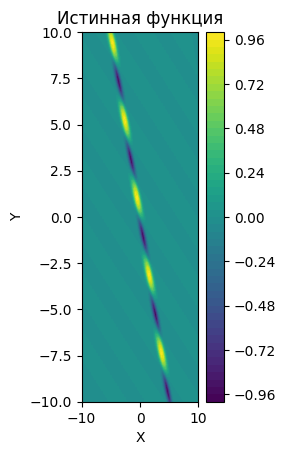

In [26]:
# Истинная функция
plt.subplot(131)
contour1 = plt.contourf(X_grid, Y_grid, Z_true, 50, cmap='viridis')
plt.colorbar(contour1)
plt.title('Истинная функция')
plt.xlabel('X')
plt.ylabel('Y')

Text(0, 0.5, 'Y')

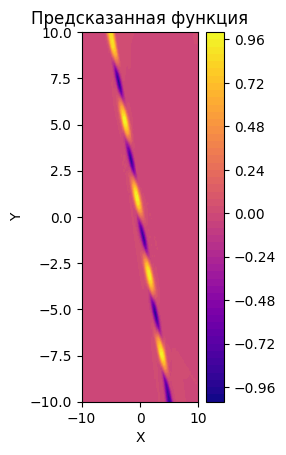

In [27]:
# Предсказанная функция
plt.subplot(132)
contour2 = plt.contourf(X_grid, Y_grid, Z_pred, 50, cmap='plasma')
plt.colorbar(contour2)
plt.title('Предсказанная функция')
plt.xlabel('X')
plt.ylabel('Y')

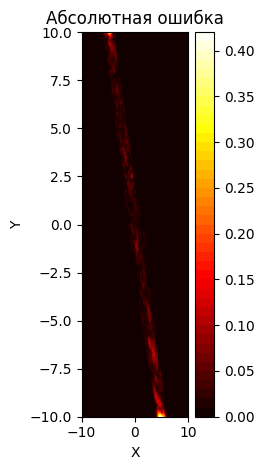

In [28]:
# Разница между истинной и предсказанной функциями
plt.subplot(133)
contour3 = plt.contourf(X_grid, Y_grid, np.abs(Z_true - Z_pred), 50, cmap='hot')
plt.colorbar(contour3)
plt.title('Абсолютная ошибка')
plt.xlabel('X')
plt.ylabel('Y')

plt.tight_layout()
plt.show()

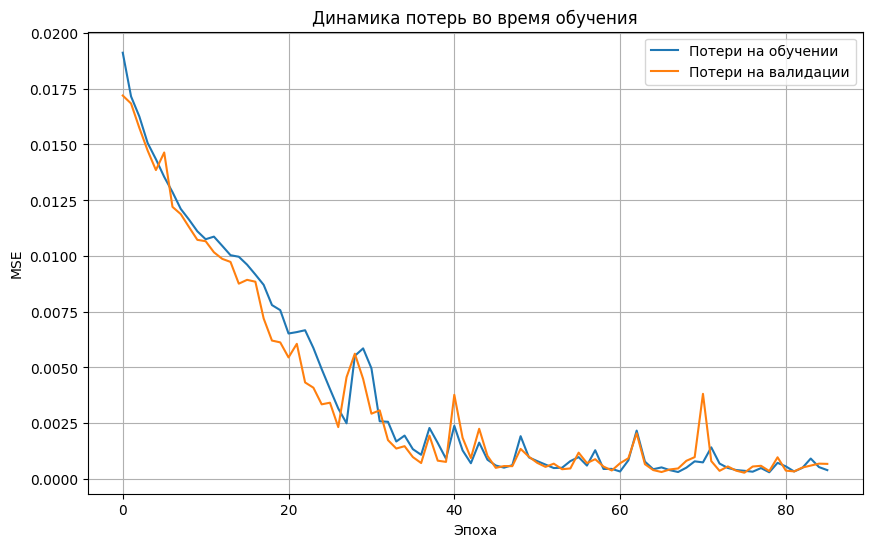

In [29]:
# График потерь во время обучения
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Потери на обучении')
plt.plot(val_losses, label='Потери на валидации')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.title('Динамика потерь во время обучения')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
# Дополнительная визуализация: сравнение истинных и предсказанных значений
# Выбираем случайные точки из тестового набора для визуализации
sample_indices = np.random.choice(len(X_test), size=100, replace=False)
X_sample = X_test[sample_indices]
y_sample_true = y_test[sample_indices]

In [31]:
# Получаем предсказания модели
X_sample_tensor = torch.FloatTensor(X_sample)
with torch.no_grad():
    y_sample_pred = model(X_sample_tensor).numpy()

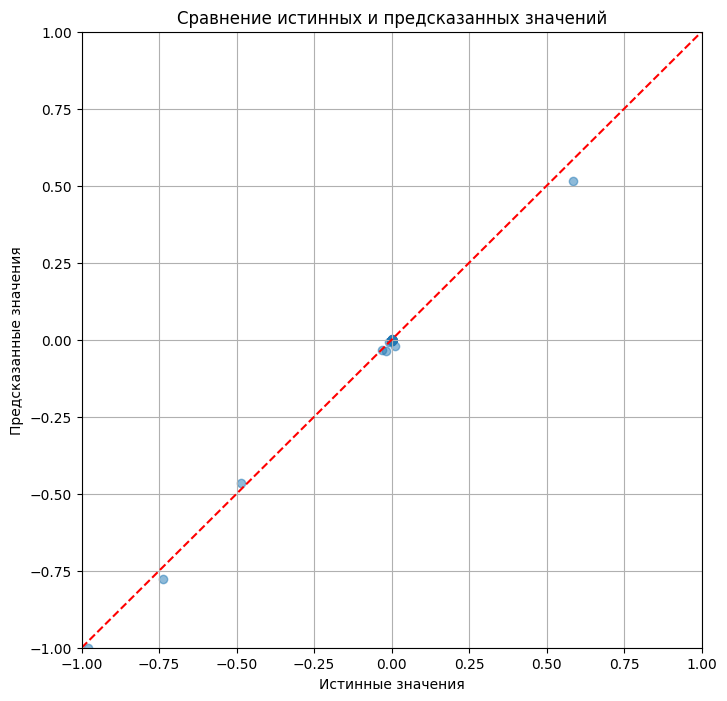

In [32]:
# Строим график сравнения
plt.figure(figsize=(8, 8))
plt.scatter(y_sample_true, y_sample_pred, alpha=0.5)
plt.plot([-1, 1], [-1, 1], 'r--')  # Линия идеального предсказания
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('Истинные значения')
plt.ylabel('Предсказанные значения')
plt.title('Сравнение истинных и предсказанных значений')
plt.grid(True)
plt.show()